In [1]:
import math
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

from datetime import datetime
from dateutil.relativedelta import relativedelta

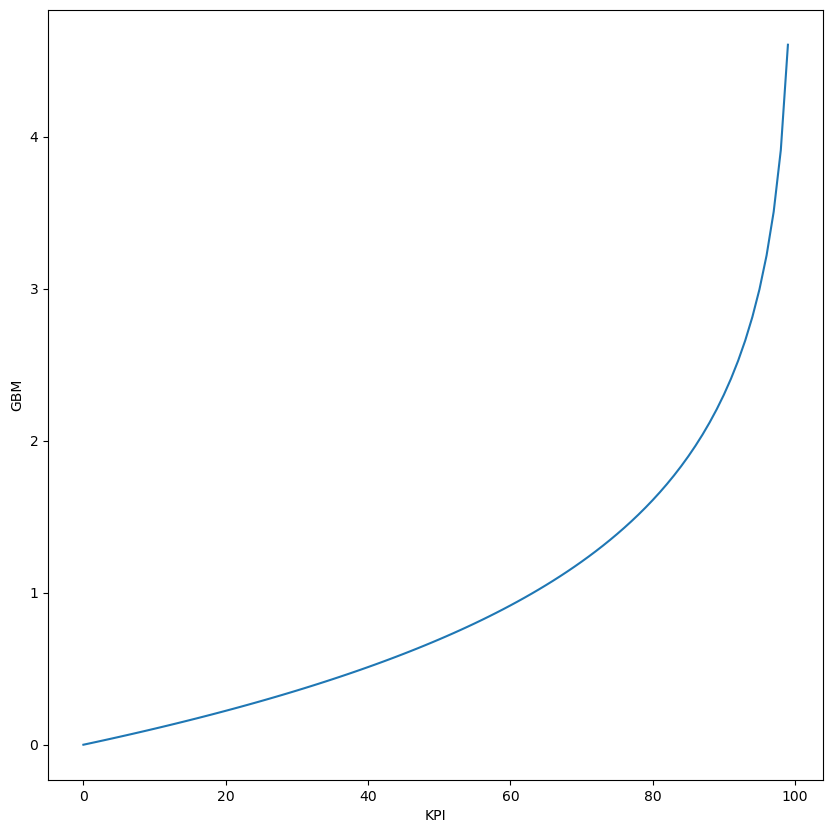

In [2]:
def convert_KPI_GBM( KPI ) : # input is range (0,100), output transformed to (0,infty) as value of GBM as an increasing function fixing 0
    return -np.log( 1 - KPI / 100 )

plt.xlabel( 'KPI' )
plt.ylabel( 'GBM' )
plt.plot( np.arange(100), convert_KPI_GBM( np.arange(100) ) )
plt.show()

In [3]:
class Contract:
    def __init__(self, KPI_goal=0, T=0, coupon_period=1/12, maturity_underlying=0, reward=0, penalty=0, principal=0, is_call=True, is_American=False ):
        self.KPI_goal = KPI_goal
        self.T = T
        self.coupon_period = coupon_period
        self.maturity_underlying = maturity_underlying # must assume that KPI's maturity <= underlying's maturity
        self.reward = reward # in units of basis points on the notional
        self.penalty = penalty
        self.principal = principal # the underlying's notional
        self.is_call = is_call
        self.is_American = is_American


In [4]:
df = pd.read_excel( "ESG Contract details.xlsx", 1, index_col=0 )
df.drop( columns=["TICKER"], inplace=True )

In [5]:
KPI_converted = convert_KPI_GBM( df['Total ESG Score'] ) # this is a numpy array
KPI_converted_ret = np.log(1+KPI_converted.pct_change())
KPI_vol = KPI_converted_ret.std() * np.sqrt(12) # annualized volatility
KPI_vol

0.11823576585032058

In [6]:
df["converted"] = KPI_converted
df

,Total ESG Score,converted
Date,,
2009-08-16,64.00,1.021651
2009-09-06,64.00,1.021651
2009-10-04,64.00,1.021651
2009-11-01,64.00,1.021651
2009-12-07,65.00,1.049822
...,...,...
2019-05-03,79.07,1.563987
2019-06-03,79.07,1.563987
2019-07-01,79.07,1.563987


In [7]:
converted_KPI_goal = convert_KPI_GBM( 81 ) # must ensure this is greater than converted_KPI_0 for american options so that we don't exercise at time 0
converted_KPI_goal

1.660731206821651

In [8]:
example_contract_euro_nope = Contract( converted_KPI_goal, 1, 1/12, 10, 10, 0, 1, True, False ) # p14 Karia's thesis : using 10bps = reward = -penalty
example_contract_amer_nope = Contract( converted_KPI_goal, 1, 1/12, 10, 10, 0, 1, True, True ) # p14 Karia's thesis : using 10bps = reward = -penalty

example_contract_euro_pena = Contract( converted_KPI_goal, 1, 1/12, 10, 10, 10, 1, True, False ) # p14 Karia's thesis : using 10bps = reward = -penalty
example_contract_amer_pena = Contract( converted_KPI_goal, 1, 1/12, 10, 10, 10, 1, True, True ) # p14 Karia's thesis : using 10bps = reward = -penalty

In [9]:
class Dynamics:
    def __init__(self, KPI_0=0., r=0., sigma=0.):
        self.KPI_0 = KPI_0
        self.r = r
        self.sigma = sigma

In [10]:
converted_KPI_0 = convert_KPI_GBM(float(df.iloc[-1,0]))
converted_KPI_0

1.5663784229736535

In [11]:
def drift_est(KPI):
    S = KPI.dropna()
    alpha_hat = S.mean()
    sigma_hat = S.std()*np.sqrt(12)
    return alpha_hat*np.sqrt(12) + (1/2*sigma_hat**2)

In [12]:
phys_drift = drift_est(KPI_converted_ret)
phys_drift

0.019224311554666335

In [13]:
example_dynamics = Dynamics( converted_KPI_0, phys_drift, KPI_vol )

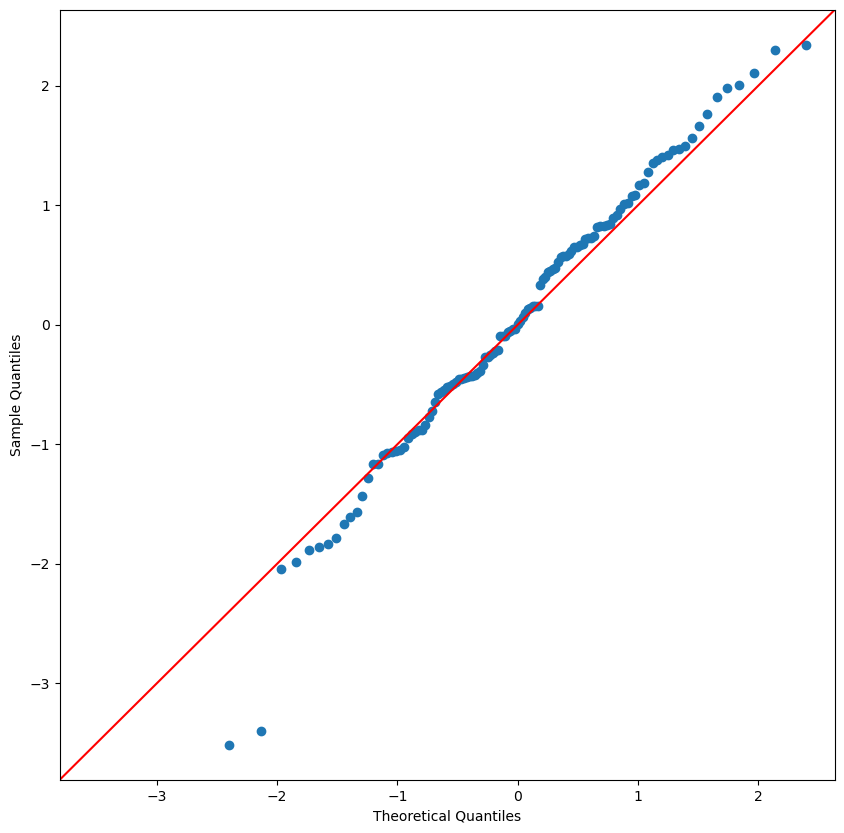

In [14]:
# In statistics, a Q-Q plot (short for quantile-quantile plot) is a 2-dim parametric curve in the plane R^2 given by x |--> ( F^-1(x), G^-1(x) ) 
# that compares two cumulative distribution functions (CDFs), say one is a model's distribution and the other is the empirical distribution from data we want model.
# A good choice of model means that the plot is as close to the diagonal y=x line as possible.  The function sm.qqplot by default compares to a standard normal CDF.
#
# However, the data are in a timeseries that is a linear transform of a Wiener stochastic process W_t = W_t-W_0 ~ N( 0, t ) with time-varying volatility to normalize.
# For educational comparative purposes, here's what a good fit would look like.
W_sim = np.random.randn( len(KPI_converted) ) * np.sqrt( range(len(KPI_converted)) )
fig = sm.qqplot( W_sim[1:] / np.sqrt( range(1,len(KPI_converted)) ), line='45' )
plt.show()

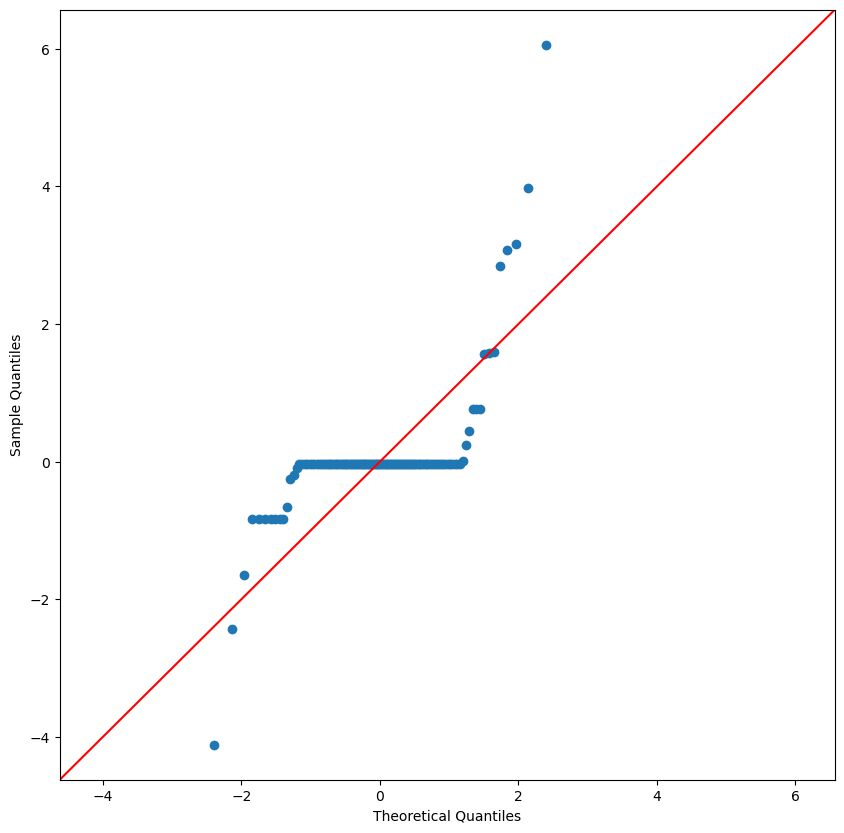

In [15]:
# However, unlike the above ideal simulation, our empirical data is badly fitted to the null hypothesis H_0 : KPI follows GBM stochastic process.
W_emp = ( np.log( KPI_converted/KPI_converted[0] ) - (example_dynamics.r-example_dynamics.sigma**2/2) * range(len(KPI_converted))/12 ) / example_dynamics.sigma
deltaW_emp = W_emp.diff().dropna()
fig = sm.qqplot( deltaW_emp / math.sqrt(1/12), line='45' )
plt.show()

In [16]:
# The Kolmogorov--Smirnov statistic compares two CDFs, say an empirical to a model distribution.
ss.kstest( W_sim[1:] / np.sqrt( range(1,len(KPI_converted)) ), ss.norm.cdf )

KstestResult(statistic=0.07947555044131638, pvalue=0.4080638801302102)

In [17]:
# Below we see that the p_value is very close to zero, much less than 1% significance for a 99% confidence interval.
# It tells us quantitatively, unlike the subjective interpretation of the Q-Q plot, that we must objectively reject hypothesis H_0.
# Nonetheless, for this UChicago Project Lab on ESG-derivative pricing for Ernst&Young, we still assume the KPI follows GBM dynamics.
ss.kstest( deltaW_emp / math.sqrt(1/12), ss.norm.cdf )

KstestResult(statistic=0.3962124348741678, pvalue=1.2169198156785725e-17)

In [18]:
class Tree: 
    def __init__(self, N=0 ):
        self.N = N

In [19]:
example_tree = Tree( 750 )

In [20]:
class MC:
    def __init__(self, M=0, seed=0, N=0, antithetic=False):
        self.M = M
        self.seed = seed
        self.N = N
        self.antithetic = antithetic

In [21]:
example_MC_noAnti = MC( 10_000, 0, 250, False )
example_MC_withAnti = MC( 10_000, 0, 250, True )

In [22]:
# specific to the contract's style of periodic disbursement after option's execution as described in Karia's masters thesis
def total_coupon_disbursement( timeT_coupon, annual_rate, option_expiryT, maturity_underlying, period=1/12 ) :
    # the time0 total price of all coupons on the "bond" created from the ESG option's exercise, with disbursements on option_expiryT < time <= maturity_underlying
    return sum( timeT_coupon * math.exp( -annual_rate * time ) for time in np.arange( option_expiryT + period, maturity_underlying + period, period ) )


# Black&ndash;Scholes Method

In [23]:
from scipy.stats import norm
def BS_call( dynamics, contract ) : # this closed form is only handles european-style binary call options
    ##Getting inputs
    S0, sigma, r = dynamics.KPI_0, dynamics.sigma, dynamics.r
    K, T, maturity_underlying = contract.KPI_goal, contract.T, contract.maturity_underlying
    coupon_period, reward, penalty, principal  = contract.coupon_period, contract.reward, contract.penalty, contract.principal
    
    ## Actual calculation
    d2 = ( math.log(S0/K) + (r - sigma**2/2) * T )/( sigma * T**0.5 ) # d2 term of Black--Scholes call equation
    return total_coupon_disbursement( principal * ( reward*norm.cdf(d2,0,1) - penalty*norm.cdf(-d2,0,1) ) /10_000, r, T, maturity_underlying, coupon_period)



In [24]:
BS_call( example_dynamics, example_contract_euro_nope )

0.03380996177064293

In [25]:
BS_call( example_dynamics, example_contract_euro_pena )

-0.029587141595506943

# Binomial Tree Method

In [42]:
def bin_tree_call( dynamics, contract, tree ) : # KPI is the underlying; unlike Karia's method, we keep track of the entire tree (no DP)
    ## Getting inputs
    #Dynamics Inputs
    KPI_0, sigma, r = dynamics.KPI_0, dynamics.sigma, dynamics.r 
    # Contract Inputs
    KPI_goal, T, maturity_underlying, coupon_period = contract.KPI_goal, contract.T, contract.maturity_underlying, contract.coupon_period
    reward, penalty, principal = contract.reward, contract.penalty, contract.principal # penalty < 0 < bonus    min units of basis points
    is_call, is_American = contract.is_call, contract.is_American # check if its a call/put or American (support for both is working)

    # Tree Inputs
    N = tree.N ; delta_t = T/N ; discount_factor = np.exp(-r*delta_t) # step size, discount over time [0,T]
    u = math.exp( sigma * math.sqrt(delta_t) ) ; d = 1/u # up down factors as per CRR
    p = ( math.exp(r*delta_t) - d ) / ( u - d ) # Risk neutral prob for underlying moving up

    payoff, scaling = np.zeros((N+1,N+1)), 1 if is_call else -1 # initialising payoff tree, adjusting payoff if call or put
    KPI, prob_tree = np.zeros((N+1,N+1)), np.zeros((N+1,N+1)) # "stock-price" tree for risk-neutral probability of reaching each node
    
    def payval( stock ) : return np.where( scaling * ( stock - KPI_goal ) >= 0, reward, -penalty ) /10_000 * principal
    
    if is_American:
        american_payoff_tree = np.zeros((N+1,N+1))
    
    for node in range( 1+N ) : # only fill in at time = N = T / delta_t
        KPI[N,node] = KPI_0 * u**node * d**(N-node)
        payoff[N,node] = ( reward if scaling * ( KPI[N,node] - KPI_goal ) >= 0 else -penalty ) /10_000 * principal
        prob_tree[N,node] = math.comb(N,node) * (p**node) * (1-p)**(N-node) # binomial coefficient
        if is_American:
            american_payoff_tree[N,node] = payoff[N,node]
            
    #support for both American and European binary calls
    if not is_American: # european-style - the @ is calculating the timeT expected value
        return total_coupon_disbursement( payoff[N] @ prob_tree[N], r, T, maturity_underlying, coupon_period )

    # american-style - the discounted payoff is the beginning of the tree (result of backward induction)
    for step in range(N-1,-1,-1): # now we are required to go backwards in time < N = T / delta_t
        for node in range(step+1): # using the martingale property of payoff to compute it via back-propagation
            KPI[step,node] = KPI_0 * u**node * d**(step-node) # as designed, relevant only for 0 <= node <= time
            payoff[step,node] = ( p*american_payoff_tree[step+1,node+1] + (1-p)*american_payoff_tree[step+1,node] ) # payoff[t] = E_t( payoff[t+1] )
            american_payoff_tree[step,node] = np.maximum( payoff[step,node], payval( KPI[step,node] ) )
    return total_coupon_disbursement( american_payoff_tree[0,0], r, T, maturity_underlying, coupon_period )

In [43]:
bin_tree_call( example_dynamics, example_contract_euro_nope, example_tree )

0.034534303714264206

In [44]:
bin_tree_call( example_dynamics, example_contract_euro_pena, example_tree )

-0.028138457708264415

In [45]:
# No-arbitrage theory predicts that american call price = european call price for VANILLA calls only.
# For BINARY calls, american call price > european call price since we exercise the first time S_t > K.
bin_tree_call( example_dynamics, example_contract_amer_nope, example_tree )

0.06235439163233461

In [46]:
bin_tree_call( example_dynamics, example_contract_amer_pena, example_tree )

0.027501718127876374

# Paper Implementation

In [31]:
###Same as paper (different result than Merton's binomial tree)
def paper_bin_tree(KPI_0,KPI_u,KPI_goal,sigma,r,T,N,observations,maturity_underlying,bps,P):
    delta_t = T/N 
    discount_factor = np.exp(-r*delta_t)
    u = 1+(KPI_u - KPI_0)/(KPI_0) # How is this calculated?  Assumes a bounded 0 < KPI < KPI_u instead of GBM?
    d = 1/u
    # sigma = np.log(u)/np.sqrt(delta_t) - why does paper calculate this if it's already a parameter here?
    p = (np.exp(r*delta_t)-d)/(u-d)
    KPI = np.zeros(N+1)
    KPI[0] = KPI_0*d**N
    #construct the final set of prices at T
    for n in range(1,N+1):
        KPI[n] = KPI[n-1]*u/d
    #option value at maturity
    payoff = np.zeros(N+1)
    for n in range(N+1):
        if KPI[n] >= KPI_goal:
            payoff[n] = bps/10000*P
        else:
            payoff[n] = 0
    
    for time in range(N,0,-1):
        for node in range(0,time):
            payoff[node] = discount_factor * ( p*payoff[node+1]+ (1-p)*payoff[node] )
    return payoff[0] * (maturity_underlying-T)*observations

In [32]:
# We do not fully trust the code from the paper, so we do not update its parameters from our dataset.
paper_bin_tree( 100, 122.14027581601698, 120, 0.2, 0.004, 1, 100, 12, 5, 5, 100 ) # different result - source of 2nd argument (122.14...)?

0.3244781890268738

# Monte Carlo

In [33]:
def MC_Pricer(contract,dynamics,MC):
    ## Getting inputs
    #Dynamics Inputs
    S0, sigma, r = dynamics.KPI_0, dynamics.sigma, dynamics.r 
    # Contract Inputs
    K, T, maturity_underlying, coupon_period = contract.KPI_goal, contract.T, contract.maturity_underlying, contract.coupon_period
    reward, penalty, principal = contract.reward, contract.penalty, contract.principal # penalty < 0 < bonus in units of basis points
    is_call, is_American = contract.is_call, contract.is_American # check if its a call/put or American (support for both is working)
    # MC Inputs (no use of a control variate)
    np.random.seed(MC.seed)  # initializing the random-number generator
    M,seed,antithetic = MC.M,MC.seed,MC.antithetic #antithetic : negate the volatililty term, to tighten confidence interval of final result
    N = MC.N ; delta_t = T/N  # time periods, step size
        
    # keeping track of stock price here
    M0 = M//2 if antithetic else M # antithetic method uses M//2 pairs whereas the simple method does only M singlets
    S_main = np.zeros((M0,N+1)) # will adjust names to be consistent; will remember the entire path when considering american-style
    if antithetic : S_anti = np.zeros((M0,N+1)) # another price tracker for antithetic variate

    # discount over each step (bermudan approximation of american), adjusting payoff if call or put
    discount_factor, scaling = math.exp(-r*delta_t), 1 if is_call else -1
    def payval( stock ) : return np.where( scaling * ( stock - K ) >= 0, reward, -penalty ) /10_000 * principal

    for path in range( M0 ) :
        S_main[path,0], drift = S0, (r-sigma**2/2) * delta_t # drift term in the brownian-motion (BM) dynamics of of log( S_t )
        if antithetic : S_anti[path,0] = S0 #start all paths with S_0
        for step in range( 1, 1+N ) :
            diffusion = sigma * delta_t**0.5 * np.random.randn() # note delta_t**0.5 * randn ~ N( 0, delta_t )
            S_main[path,step] = S_main[path,step-1] * math.exp( drift + diffusion ) # sum for main stock
            if antithetic : S_anti[path,step] = S_anti[path,step-1] * math.exp( drift - diffusion ) # difference for anti stock
    
    if not is_American : # european-style
        MC_price = np.mean( payval( S_main[:,N] ) )
        if antithetic :
            MC_price += np.mean( payval( S_anti[:,N] ) )
            MC_price /= 2 # averaging here reduces overall variance from the simulation
        return total_coupon_disbursement( MC_price, r, T, maturity_underlying, coupon_period )

    # american-style --- use the biggest discounted ( payoff average over simulations at a given time step)
    MC_price = sum( np.amax( payval( S_main[path,:] ) * np.power( discount_factor, range( 1+N ) ) ) for path in range( M0 )  ) / M0
    if antithetic :
        MC_price += sum( np.amax( payval( S_anti[path,:] ) * np.power( discount_factor, range( 1+N ) ) ) for path in range( M0 )  ) / M0
        MC_price /= 2
    MC_price *= math.exp( r*T ) # move forward to get a timeT price
    return total_coupon_disbursement( MC_price, r, T, maturity_underlying, coupon_period )

In [47]:
MC_answers, seed_max = {}, 50
example_MC_noAnti = [ MC( 10_000, seed, 250, False ) for seed in range(seed_max) ]
example_MC_withAnti = [ MC( 10_000, seed, 250, True ) for seed in range(seed_max) ]

MC_answers['euro, no penalty, no antithetic'] = ( example_contract_euro_nope, example_dynamics, example_MC_noAnti )
MC_answers['euro, no penalty, with antithetic'] = ( example_contract_euro_nope, example_dynamics, example_MC_withAnti )

MC_answers['amer, no penalty, no antithetic'] = ( example_contract_amer_nope, example_dynamics, example_MC_noAnti )
MC_answers['amer, no penalty, with antithetic'] = ( example_contract_amer_nope, example_dynamics, example_MC_withAnti )

MC_answers['euro, with penalty, no antithetic'] = ( example_contract_euro_pena, example_dynamics, example_MC_noAnti )
MC_answers['euro, with penalty, with antithetic'] = ( example_contract_euro_pena, example_dynamics, example_MC_withAnti )

MC_answers['amer, with penalty, no antithetic'] = ( example_contract_amer_pena, example_dynamics, example_MC_noAnti )
MC_answers['amer, with penalty, with antithetic'] = ( example_contract_amer_pena, example_dynamics, example_MC_withAnti )


In [49]:
for key,val in MC_answers.items() : MC_answers[key] = np.array( [ MC_Pricer( val[0], val[1], val[2][seed] ) for seed in range(seed_max) ] )

for key,val in MC_answers.items() : MC_answers[key] = ( val.mean(), val.std() )

pd.DataFrame( columns=['style, contract, MC method', 'seed mean', 'seed stdev'], data=[ [ k, *v ] for k,v in MC_answers.items() ] )

,"style, contract, MC method",seed mean,seed stdev
0,"euro, no penalty, no antithetic",0.033707,0.000500
1,"euro, no penalty, with antithetic",0.033784,0.000370
2,"amer, no penalty, no antithetic",0.061681,0.000530
3,"amer, no penalty, with antithetic",0.061673,0.000312
4,"euro, with penalty, no antithetic",-0.029792,0.001000
5,"euro, with penalty, with antithetic",-0.029640,0.000740
6,"amer, with penalty, no antithetic",0.025372,0.001053
7,"amer, with penalty, with antithetic",0.025358,0.000623


There exist other methods that involve linear regression for pricing bermudan puts, namely the Longstaff&ndash;Schwartz method.

# Interest Rate Swap (IRS) Pricer

In [36]:
historical_libor = pd.read_excel("USD LIBOR and SOFR data.xlsx",sheet_name = 'Original extract')
historical_libor = historical_libor.loc[::-1]
historical_libor['Date'] = pd.to_datetime(historical_libor['Date'],format = '%d.%m.%Y')
historical_libor.set_index('Date',inplace=True)
historical_libor.drop(columns = ['Week day'],inplace=True)
historical_libor.dropna(inplace=True)

historical_libor

,ON,1W,1M,2M,3M,6M,12M
Date,,,,,,,
2001-01-02,6.65125,6.60500,6.54750,6.45875,6.37125,6.16375,5.94250
2001-01-03,6.65375,6.57875,6.50750,6.39375,6.28625,6.05375,5.78875
2001-01-04,6.09625,6.08125,6.05000,5.95375,5.86625,5.70750,5.55500
2001-01-05,6.01625,6.05250,5.93625,5.80500,5.69500,5.51625,5.36500
2001-01-08,6.01500,6.03750,5.88375,5.75000,5.61625,5.41938,5.30250
...,...,...,...,...,...,...,...
2021-12-23,0.07513,0.07513,0.10188,0.15563,0.21975,0.33638,0.56113
2021-12-24,0.06975,0.07325,0.10125,0.14938,0.21788,0.34325,0.56713
2021-12-29,0.07275,0.07650,0.10425,0.15825,0.22375,0.35438,0.58600


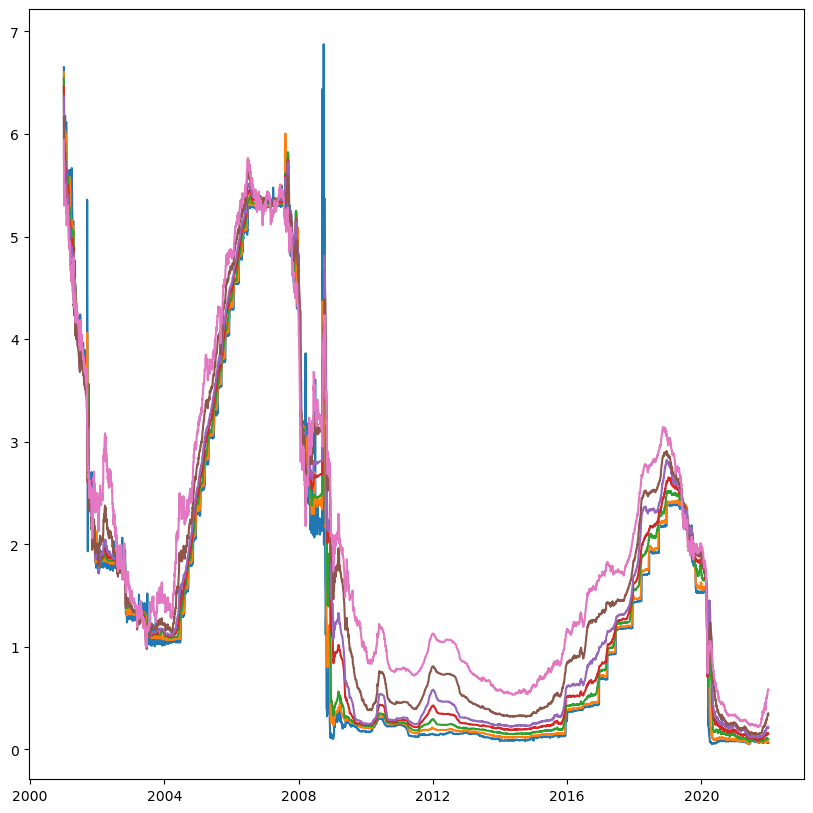

In [37]:
plt.plot(historical_libor)

In [38]:
class IRSContract:
    def __init__(self,fixed,floating,start_date,payment_frequency,maturity,notional,long):
        self.fixed = fixed
        self.floating = floating
        self.start_date = start_date
        self.payment_frequency = payment_frequency
        self.maturity = maturity
        self.notional = notional
        self.long = long

In [39]:
example_IRSContract = IRSContract( 0.025, historical_libor, '2015-10-20', 1, 10, 10_000_000, True )

In [40]:
def IRS_pricer(contract):
    start_date = pd.to_datetime(contract.start_date)
    payment_frequency = contract.payment_frequency
    maturity = contract.maturity
    fixed_rate = contract.fixed

    print(payment_frequency)
    period = { 1:'12M', 1/2:'6M', 1/4:'3M', 1/6:'2M', 1/12:'1M', 1/365:'ON' }
    floating_series = contract.floating.loc[ start_date:start_date+relativedelta(years = maturity), period[payment_frequency] ] /100
    
    print(start_date)
    print(start_date+relativedelta(years = maturity))
    discount_factor = 1 / ( 1 + floating_series / 4 ) #simple rate
    fair_swap = ( 1 - discount_factor[-1] ) / sum( discount_factor )  #determined by yield curve at initiation of contract
    price = contract.notional * (fair_swap-fixed_rate) * sum(discount_factor)
    return price if contract.long else -price    

In [41]:
IRS_pricer( example_IRSContract )

1
2015-10-20 00:00:00
2025-10-20 00:00:00


-382764809.28044766